In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from IPython.display import display, HTML
import sys,os
import pandas as pd
import copy

sys.path.insert(0, '../scripts/')
from nlp_preprocess import *
from custom_transformers import *
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /user-home/1077/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Modelling and Sampling Libraries.

In [2]:
%matplotlib inline
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score,average_precision_score,auc,roc_auc_score,roc_curve, precision_recall_curve,fbeta_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.ensemble import BalanceCascade
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.under_sampling import (RandomUnderSampler, 
                                    NearMiss, 
                                    InstanceHardnessThreshold,
                                    CondensedNearestNeighbour,
                                    EditedNearestNeighbours,
                                    RepeatedEditedNearestNeighbours,
                                    AllKNN,
                                    NeighbourhoodCleaningRule,
                                    OneSidedSelection,
                                    TomekLinks)
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline,Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,HashingVectorizer,CountVectorizer
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

### Retrieve the Prepared Dataset for 4 Clauses

In [181]:
%store -r breach_final_df
data = breach_final_df

In [182]:
data.head()
data = data.drop_duplicates()

In [183]:
# data_final = data[['Breach','keyword_corpus']]
# data_final.head()

### Preprocessing the data and  creating a feature Pipeline


In [184]:
X = data.drop('Breach', axis=1) 
Y = data['Breach']

In [185]:
def tokenizer(x):
     return x

### Initialise the Custom Transformers from the custom_transformers.py script

### Dataframe Feature and Cleansing Transformers

In [186]:
scale_pos_weight = float(np.float(np.sum(data.Breach==0)))/float(np.float(np.sum(data.Breach==1)))
drop_transf = DropFeatures(column_list=['ConcernID','IssueID','IssueDescription','ConcernDescription','ResolutionDescription','Clause'])
transformer = DataFrameTransformer(column='keyword_corpus')
#final_drop = DropFeatures(column_list=['keyword_corpus'])

### Feature Extraction and Formation





In [187]:
columnextract = ColumnExtractorTransformer(column='features')
tfidf = TfidfVectorizer(tokenizer=tokenizer, lowercase=False)

### Synthetic Minority Oversampling Technique, ADASYN and Other Advanced Feature Engineering Techniques

In [188]:
adasyn = ADASYN(random_state=42)
smt = SMOTE(random_state=42)
und = RandomUnderSampler(random_state=42)

### Initialise the Classifier

In [277]:
scale_pos_weight = float(np.float(np.sum(data.Breach==0)))/float(np.float(np.sum(data.Breach==1)))

###98% Recall
#xgb1 = XGBClassifier(learning_rate=0.01,max_delta_step=1,max_depth=3,min_child_weight=1,scale_pos_weight=scale_pos_weight)

###44% Precision
#xgb1 = XGBClassifier(learning_rate=0.5,max_delta_step=1,max_depth=5,min_child_weight=1)

### 68% Precision with no sampling
xgb1 = XGBClassifier(learning_rate=0.002,n_estimators=500,max_depth=3)
from sklearn.naive_bayes import GaussianNB
# gauss = GaussianNB()

svm1= svm.SVC(kernel='linear',C=1.0)
lr1 = LogisticRegression(C=10,penalty='l2', verbose=5,dual=True,max_iter=1000)

### Initiliase and form a feature Pipeline using Imblearn/Sklearn Pipeline and Split the Dataset as Train, Text

In [278]:
text_model_pipeline = Pipeline([('drop_transf',drop_transf),('transformer',transformer),('columnextract',columnextract),('tfidf', tfidf),
                              ('xgb1', xgb1)])
# text_model_pipeline = Pipeline([('drop_transf',drop_transf),('transformer',transformer),('columnextract',columnextract),('tfidf', tfidf),('adasyn',adasyn),
#                                 ('xgb1', xgb1)])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.20, random_state=42)

### GridSearchCV for Model and paramter selection

In [279]:
##LR Params
parameters = {
    'C': np.linspace(1, 10, 10),
    'dual' :[True,False],
    'max_iter':[100,110,120,130,140]
}


### RF Params
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}


### XGB Params
cv_params = {
    'min_child_weight':[0.2,1],
    'max_delta_step': [1],
    'max_depth':[5,8],
    'learning_rate' : [0.1]
}

ind_params = {
    'learning_rate': 0.1, 'n_estimators': 5000, 'seed':0, 'colsample_bytree': 0.8,'scale_pos_weight':6.55,'n_jobs':-1, 'objective': 'binary:logistic'
}

##SVM Params
Cs = [0.001]
gammas = [0.001]
param_grid = {'C': Cs, 'gamma' : gammas}

### Model Initialization and GridSearch

# lr = LogisticRegression()
#rf = RandomForestClassifier()

# clf = GridSearchCV(lr, parameters, cv=StratifiedKFold(5), verbose=5, n_jobs=3)
#clf = GridSearchCV(rf, param_grid, cv=StratifiedKFold(5), verbose=5, n_jobs=3)


# drop_transf = DropFeatures(column_list=['ConcernID','IssueID','IssueDescription','ConcernDescription','ResolutionDescription','Clause'])
# transformer = DataFrameTransformer(column='keyword_corpus')
#final_df = transformer.transform(X=data)

kfold = StratifiedKFold(5)
#clf = GridSearchCV(text_model_pipeline,cv_params,cv=5)
# clf = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=StratifiedKFold(5))


#clf.fit(X_train, Y_train)

In [280]:
# clf = GridSearchCV(text_model_pipeline,cv_params,cv=5)
# clf.fit(X_train,Y_train)
# print(clf.best_score_)
# print(clf.best_estimator_.get_params())

### XGB Classifier Hyperparameter Tuning

### Train and Fit the Pipeline and underlying components

In [281]:
text_model_pipeline.fit(X_train, Y_train) 

Pipeline(memory=None,
     steps=[('drop_transf', DropFeatures(column_list=['ConcernID', 'IssueID', 'IssueDescription', 'ConcernDescription', 'ResolutionDescription', 'Clause'])), ('transformer', DataFrameTransformer(column='keyword_corpus')), ('columnextract', ColumnExtractorTransformer(column='features')), ('tfidf', TfidfVe...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

### Test the Model Performance on Test dataset

In [282]:
y_hat = text_model_pipeline.predict(X_test)

### Compute the Recall and Precision : Metrics for measuring the Classification Model

In [283]:
print("Recall {0:.2f}".format(recall_score(Y_test,y_hat)))
print("Precision {0:.2f}".format(precision_score(Y_test,y_hat)))
print("F1 {0:.2f}".format(f1_score(Y_test,y_hat)))

Recall 0.11
Precision 0.70
F1 0.19


### Compute F1 Score

In [ ]:
# precision = precision_score(y_hat,Y_test)
# recall = recall_score(Y_test,y_hat)
# f1 = 2*((precision*recall)/(precision+recall))
# f1

### Confusion Matrix

Text(0.5,24,'Predicted label')

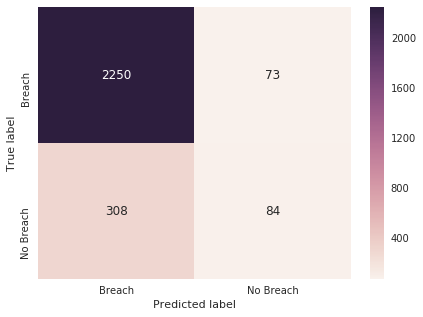

In [267]:
import seaborn as sns

conf_mat = confusion_matrix(Y_test, y_hat)

# Define class labels here
target_names = ['Breach','No Breach']

df_cm = pd.DataFrame(conf_mat, index=target_names, columns=target_names)
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(df_cm, annot=True, fmt="d", ax=ax)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

In [268]:
conf_mat

array([[2250,   73],
       [ 308,   84]])

### Precision/Recall Curve

Average precision-recall score: 0.23


Text(0.5,1,'2-class Precision-Recall curve: AP=0.23')

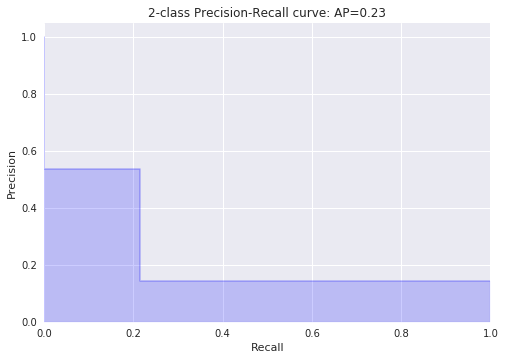

In [269]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(Y_test,y_hat)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(Y_test, y_hat)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

### PR Curve

f1=0.306 auc=0.403 ap=0.405


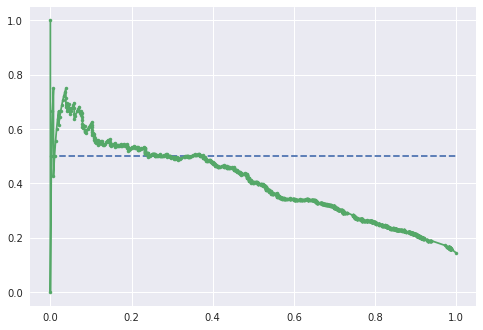

In [276]:
from matplotlib import pyplot
# predict probabilities
probs = text_model_pipeline.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = text_model_pipeline.predict(X_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, probs)
# calculate F1 score
f1 = f1_score(Y_test, yhat)
# calculate precision-recall AUC
from sklearn.metrics import auc
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(Y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()

### Retreive Results in Source format

In [52]:
x_test = pd.DataFrame(X_test)
x_test.head()
Y_test_df = pd.DataFrame(Y_test, columns=['Breach'])
Y_test_df["Predicted_Breach"] = y_hat
Y_test_df.head()

,Breach,Predicted_Breach
32827,0.0,0.0
2366,0.0,0.0
3364,0.0,0.0
6827,0.0,0.0
19126,0.0,0.0


In [53]:
new_df = data[data.index.isin(Y_test_df.index)]
new_df.drop(['Breach'],axis=1,inplace=True)
df = new_df.join(Y_test_df)
df.head()

,ConcernID,IssueID,IssueDescription,ConcernDescription,ResolutionDescription,Clause,keyword_corpus,Breach,Predicted_Breach
49,971112,1020452,account opened in different name than business...,you visited ANZ Bourke Street Mall branch on 1...,Thank you for the opportunity to investigate t...,15,you visited ANZ Bourke Street Mall branch on 1...,0.0,0.0
161,COM-100003,COM-100003_1,rewards fee,***credit card Customer is not happy with pa...,Acknowledged his dissatisfaction of the reward...,14a,***credit card Customer is not happy with pa...,0.0,0.0
163,COM-100006,COM-100006_1,Poor service,Customer dissatisfied with the service he rece...,Apologised to customer and informed him feedba...,15,Customer dissatisfied with the service he rece...,0.0,0.0
179,COM-100033,COM-100033_1,Retention offer cancelled and reverted to the ...,15/06 ? Retention offer of 12.99% p.a The var...,I apologise to the customer for the inconvenie...,14a,15/06 ? Retention offer of 12.99% p.a The var...,0.0,0.0
187,COM-100037,COM-100037_1,Incorrect information by branch,Customer sold bike for $1900.00. The purchaser...,Credited account for $1900.00. Case found in c...,15,Customer sold bike for $1900.00. The purchaser...,0.0,0.0


In [54]:
df.groupby('Clause').sum()
#df_save = df.drop(['features','keyword_corpus'],axis =1)
#df.to_csv("../datasets/map_pred_actual_68.csv")
df.to_csv("../datasets/map_pred_actual_98.csv")
# df_test = df[df['Breach']==0]
# df_test.to_csv("../datasets/map_precision_68.csv")
df_test = df[df['Breach']==1]
df_test.to_csv("../datasets/map_precision_98.csv")

### Save the Model

In [30]:
from dsx_ml.ml import save
model_name = "Binary_Classification_model"
x_test = pd.DataFrame(X_test)
Y_test_df = pd.DataFrame(Y_test, columns=['Breach'])
save(model = text_model_pipeline, name = 'Breach_Detection', x_test=x_test, y_test=Y_test_df, algorithm_type = 'Classification')


{'path': '/user-home/1077/DSX_Projects/Complaints_Breach_Labelled/models/Breach_Detection/1',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python35/scikit-learn-0.20/Complaints_Breach_Labelled/Breach_Detection/1'}

In [ ]:
# text_clean = TextCleaningTransformer(column='keyword_corpus',remove_words=my_stop_words)
# #df= text_clean.transform(X=data)
# #df.head()
# tokenise = TokenizerTransfomer(column='keyword_corpus')

In [ ]:
# df= text_clean.transform(X=data)
# final_d = tokenise.transform(X=df)


In [ ]:
# final_d.columns = ['features']
# data['features'] = final_d['features']
# final_df = data[['Breach','features']]
# drop_transf = DropFeatures(column_list=['ConcernID','IssueID','IssueDescription','ConcernDescription','ResolutionDescription','Clause'])
# transformer = DataFrameTransformer(column='keyword_corpus')
# transf = drop_transf.transform(X=data)
# final_df = transformer.transform(X=data)

In [ ]:
# final_df.shape

### Split Train and Text Pipeline

In [ ]:
# X = final_df.drop('Breach', axis=1) 
# Y = final_df['Breach']


In [ ]:
#X_train, X_test, Y_train, Y_test = train_test_split(X['features'], Y, stratify=Y, test_size=0.25, random_state=42)

In [ ]:
# def tokenizer(x):
#     return x

### Feature Transformation ; can be put in pipeline

In [ ]:
# tfidf = TfidfVectorizer(tokenizer=tokenizer, lowercase=False,ngram_range=(1,2))
# from sklearn.model_selection import train_test_split,StratifiedKFold
# #hashdf = HashingVectorizer(tokenizer=lambda x: str(x), lowercase=False)
# X_train = tfidf.fit_transform(X_train)
# X_test = tfidf.transform(X_test)
# X.shape,Y.shape

In [ ]:
# X_train.shape,X_test.shape

In [ ]:
# smt = SMOTE(random_state=42)
# #msmote = SMOTEENN(random_state=56)
# adasyn = ADASYN(random_state=42)
# x_train_1, y_train_1 = adasyn.fit_sample(X_train, Y_train)
# #x_train, y_train = smt.fit_sample(x_train_1, y_train_1)

### GridSearch ,StratifiedKFold and Model Selection

In [ ]:
##LR Params
parameters = {
    'C': np.linspace(1, 10, 10),
    'dual' :[True,False],
    'max_iter':[100,110,120,130,140]
}


### RF Params
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}


### XGB Params
cv_params = {
    'min_child_weight':[0.2,0.1],
    'max_delta_step': [1],
    'max_depth':[5,8],
    'learning_rate' : [0.09,0.02],
}

ind_params = {
    'learning_rate': 0.1, 'n_estimators': 5000, 'seed':0, 'colsample_bytree': 0.8,'scale_pos_weight':6.55,'n_jobs':-1, 'objective': 'binary:logistic'
}

##SVM Params
Cs = [0.001]
gammas = [0.001]
param_grid = {'C': Cs, 'gamma' : gammas}

### Model Initialization and GridSearch

# lr = LogisticRegression()
#rf = RandomForestClassifier()

# clf = GridSearchCV(lr, parameters, cv=StratifiedKFold(5), verbose=5, n_jobs=3)
#clf = GridSearchCV(rf, param_grid, cv=StratifiedKFold(5), verbose=5, n_jobs=3)

kfold = StratifiedKFold(5)
clf = GridSearchCV(XGBClassifier(**ind_params),cv_params,cv=5)

# clf = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=StratifiedKFold(5))

#clf.fit(x_train, y_train)
#clf.fit(X_train, Y_train)



In [ ]:
# clf.best_params_

### XGBoost

In [ ]:
#scale_pos_weight = float(np.float(np.sum(data.Breach==0)))/float(np.float(np.sum(data.Breach==1)))
# xgb1 = XGBClassifier(learning_rate=0.09,max_delta_step=1,max_depth=8,min_child_weight=0.2,scale_pos_weight=scale_pos_weight)
# xgb1.fit(x_train_1,y_train_1)
# pca = PCA(0.95)
# pca.fit(x_train)
# x_train = pca.transform(x_train)
#xgb1.fit(x_train,y_train)

In [ ]:
#X_test = pca.transform(X_test)
# xgb_pred = xgb1.predict(X_test)

In [ ]:
# print("Recall {0:.2f}".format(recall_score(Y_test,xgb_pred)))
# #print("Accuracy {0:.2f}".format(accuracy_score(xgb_pred,Y_test)))
# print("Precision {0:.2f}".format(precision_score(xgb_pred,Y_test)))
# #print("F1 Score: {0:.2f}".format(f1_score(Y_test,xgb_pred)))

In [ ]:
# precision = precision_score(xgb_pred,Y_test)
# recall = recall_score(Y_test,xgb_pred)
# f1 = 2*((precision*recall)/(precision+recall))
# f1

### Pipeline Level Steps

In [ ]:
# def tokenizer(x):
#     return x

In [ ]:
# scale_pos_weight = float(np.float(np.sum(data.Breach==0)))/float(np.float(np.sum(data.Breach==1)))
# drop_transf = DropFeatures(column_list=['ConcernID','IssueID','IssueDescription','ConcernDescription','ResolutionDescription','Clause'])
# transformer = DataFrameTransformer(column='keyword_corpus')
# final_drop = DropFeatures(column_list=['keyword_corpus'])
# tfidf = TfidfVectorizer(tokenizer=tokenizer, lowercase=False)
# adasyn = ADASYN(random_state=42)
# scale_pos_weight = float(np.float(np.sum(final_df.Breach==0)))/float(np.float(np.sum(final_df.Breach==1)))
# #print(scale_pos_weight)
# xgb1 = XGBClassifier(learning_rate=0.09,max_delta_step=1,max_depth=8,min_child_weight=0.2,scale_pos_weight=scale_pos_weight)


### Build Pipeline to Enable Model Deployment

In [ ]:
# pipeline = Pipeline([('tfidf', tfidf),('adasyn', adasyn), ('xgb', xgb1)])
# X = final_df.drop('Breach', axis=1) 
# Y = final_df['Breach']

# X_train, X_test, Y_train, Y_test = train_test_split(X['features'], Y, stratify=Y, test_size=0.20, random_state=42)

In [ ]:
# pipeline.fit(X_train, Y_train) 
# y_hat = pipeline.predict(X_test)

In [ ]:
# print("Recall {0:.2f}".format(recall_score(Y_test,y_hat)))
# print("Accuracy {0:.2f}".format(accuracy_score(y_hat,Y_test)))
# print("Precision {0:.2f}".format(precision_score(y_hat,Y_test)))

In [ ]:
# precision = precision_score(y_hat,Y_test)
# recall = recall_score(Y_test,y_hat)
# f1 = 2*((precision*recall)/(precision+recall))
# f1

In [ ]:
# from xgboost import plot_importance
# fig, ax = plt.subplots(figsize=(10,5))
# plot_importance(xgb1.get_booster(),ax)

In [ ]:
# from matplotlib import pyplot
# pyplot.bar(range(len(xgb1.feature_importances_)), xgb1.feature_importances_)
# pyplot.show()

### Save the Model 

In [ ]:
# x_test = pd.DataFrame(X_test)
# x_test.head()

In [ ]:
# Y_test_df = pd.DataFrame(Y_test, columns=['Breach'])
# Y_test_df["Predicted_Breach"] = y_hat
# Y_test_df.head()
# len(Y_test_df)

In [ ]:
# new_df = data[data.index.isin(Y_test_df.index)]
# new_df.drop(['Breach'],axis=1,inplace=True)
# df = new_df.join(Y_test_df)
# df.head()
# df.groupby('Clause').sum()
# df_save = df.drop(['features','keyword_corpus'],axis =1)
# df_save.to_csv("../datasets/map_pred_actual.csv")

In [ ]:
# df_test = df[df['Breach']==1]
# df_test.to_csv("../datasets/map_recall")

### Model Saving

In [ ]:
# from dsx_ml.ml import save
# model_name = "Binary_Classification_model"
# x_test = pd.DataFrame(X_test)
# Y_test_df = pd.DataFrame(Y_test, columns=['Breach'])
# save(model = pipeline, name = 'Compliance_Breach_Detection', x_test=x_test, y_test=Y_test_df, algorithm_type = 'Classification')

### Non Linear SVM

In [22]:
svm1 = svm.SVC(kernel='rbf')
# svm1.fit(x_train,y_train)

In [ ]:
# pred = svm1.predict(X_test)

### Linear SVM

In [ ]:
svm2 = svm.LinearSVC()
svm2.fit(x_train_1,y_train_1)

In [ ]:
pred = svm2.predict(X_test)

In [ ]:
print("Recall {0:.2f}".format(recall_score(Y_test,pred)))
print("Accuracy {0:.2f}".format(accuracy_score(pred,Y_test)))
print("Precision {0:.2f}".format(precision_score(pred,Y_test)))
print("F1 Score: {0:.2f}".format(f1_score(Y_test,pred)))

### Random Forest

In [ ]:
rfc1=RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 200, max_depth=8, criterion='gini')
rfc1.fit(x_train, y_train)

In [ ]:
pred=rfc1.predict(X_test)
print("Recall {0:.2f}".format(recall_score(Y_test,pred)))
print("Accuracy {0:.2f}".format(accuracy_score(pred,Y_test)))
print("Precision {0:.2f}".format(precision_score(pred,Y_test)))
print("F1 Score: {0:.2f}".format(f1_score(Y_test,pred)))

### Logistic Regression

In [ ]:
lr1 = LogisticRegression(C=10,penalty='l2', verbose=5,dual=True,max_iter=100)
lr1.fit(x_train, y_train)

In [ ]:
pred = lr1.predict(X_test)
print("Recall {0:.2f}".format(recall_score(Y_test,pred)))
print("Accuracy {0:.2f}".format(accuracy_score(pred,Y_test)))
print("Precision {0:.2f}".format(precision_score(pred,Y_test)))
print("F1 Score: {0:.2f}".format(f1_score(Y_test,pred)))

### Classification Report on Test Set

In [ ]:
print(confusion_matrix(Y_test, pred))
print(classification_report(Y_test, pred, target_names=['No Breach','Breach']))

In [ ]:
print("Recall {}".format(recall_score(Y_test,pred)))
print("Accuracy {}".format(accuracy_score(pred,Y_test)))
print("F1 Score: {}".format(f1_score(Y_test,pred)))

### Confusion Matrix

In [ ]:
import seaborn as sns

conf_mat = confusion_matrix(Y_test, xgb_pred)

# Define class labels here
target_names = ['NO Breach','Breach']

df_cm = pd.DataFrame(conf_mat, index=target_names, columns=target_names)
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(df_cm, annot=True, fmt="d", ax=ax)
ax.set_ylabel('True label');
ax.set_xlabel('Predicted label');

### ROC and PR Curve

In [ ]:
#prob = pd.DataFrame(list(rfc1.predict_proba(X_test)))
prob = pd.DataFrame(list(xgb1.predict_proba(X_test)))
fpr, tpr, thresholds = roc_curve(Y_test, prob.iloc[:,1])
roc_auc = auc(fpr, tpr)
p, r, thre = precision_recall_curve(Y_test, prob.iloc[:,1])
average_p = average_precision_score(Y_test, prob.iloc[:,1])

In [ ]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PR Curve')


ax1.plot(fpr, tpr, lw=1, label='LR: area = %0.2f'%roc_auc)



ax2.plot(r, p, lw=1, label='LR: area = %0.2f'%average_p)


ax1.legend(loc='lower right')    
ax2.legend(loc='lower right')

plt.show()